In [ ]:
import os
import scipy
import numpy as np
import pylab as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from pandas import read_csv
import matplotlib.pyplot as plt
from matplotlib import pyplot as mp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.io import savemat, loadmat
from scipy.stats import pointbiserialr
from matplotlib.patches import Circle
from sklearn import datasets, linear_model
from scipy.stats import probplot, pearsonr
from matplotlib.cbook import get_sample_data
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import scale 
# from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,AnnotationBbox)

### Configure environment

In [ ]:
dACC_group=[]
L_dlPFC_group=[]
R_dlPFC_group=[]
L_IFG_group=[]
R_IFG_group=[]
conflict_group=[]
adapt_group=[]
rt_group=[]

dACC_group_hc=[]
L_dlPFC_group_hc=[]
R_dlPFC_group_hc=[]
L_IFG_group_hc=[]
R_IFG_group_hc=[]
conflict_group_hc=[]
adapt_group_hc=[]
rt_group_hc=[]

dACC_group_pts=[]
L_dlPFC_group_pts=[]
R_dlPFC_group_pts=[]
L_IFG_group_pts=[]
R_IFG_group_pts=[]
conflict_group_pts=[]
adapt_group_pts=[]
rt_group_pts=[]

regions=['dACC','L_dlPFC','R_dlPFC','L_IFG','R_IFG']
variables=['rt','adapt','conflict']
raw_behav_dir='/Users/emilyhahn/projects/msit_modeling/behavior_preproc/msit_mri_behav'
preproc_behav_dir='/Users/emilyhahn/projects/msit_modeling/behavior_preproc/completed'
LSS_dir='/Users/emilyhahn/projects/msit_modeling/LSS_AVG'
LSS_estim_dir='/Users/emilyhahn/projects/msit_modeling/LSS_AVG_estim'
censor_dir='/Users/emilyhahn/projects/msit_modeling/censor_data'

df=pd.DataFrame({'group':[],'subject':[],'dACC':[],'L_IFG':[],'R_IFG':[],'L_dlPFC':[],'R_dlPFC':[],'trial':[],'cond':[],'acc':[],'rt':[],'conflict':[],'adapt':[]})
df_I=pd.DataFrame({'group':[],'subject':[],'dACC':[],'L_IFG':[],'R_IFG':[],'L_dlPFC':[],'R_dlPFC':[],'trial':[],'cond':[],'acc':[],'rt':[],'conflict':[],'adapt':[]})
df_C=pd.DataFrame({'group':[],'subject':[],'dACC':[],'L_IFG':[],'R_IFG':[],'L_dlPFC':[],'R_dlPFC':[],'trial':[],'cond':[],'acc':[],'rt':[],'conflict':[],'adapt':[]})
df_I_C=pd.DataFrame({"group":[],"subject":[],'rt':[],'dACC':[],'L_IFG':[],'R_IFG':[],'L_dlPFC':[],'R_dlPFC':[],'acc':[],'conflict':[],'adapt':[]})
# df_I_C=pd.DataFrame({"group":[],"subject":[],'rt':[]})

### Define Subjects

In [ ]:
# SUBJ_LIST = ['hc001','hc002','hc003','hc004','hc005','hc006','hc009','hc010','hc011',\
#              'hc012','hc014','hc015','hc017','hc018','hc019','hc021','hc023','hc028',\
#              'hc031','hc032','hc033','hc034','hc036','hc038','hc042']
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# SUBJ_LIST = ['pp001','pp002','pp003','pp004','pp005','pp006','pp007','pp008',\
#              'pp010','pp011','pp012','pp013','pp015','pp016']
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## hc031 -- resolve NaN issue for rt
SUBJ_LIST = ['hc001','hc002','hc003','hc004','hc005','hc006','hc009','hc010','hc011',\
             'hc012','hc014','hc015','hc017','hc018','hc019','hc021','hc023','hc028',\
             'hc032','hc033','hc034','hc036','hc038','hc042','pp001','pp002',\
             'pp003','pp004','pp005','pp006','pp007','pp008','pp010','pp011','pp012',\
             'pp013','pp015','pp016']

### Define Functions - Data Structs

In [ ]:
def normalize(arr): return (arr - arr.min()) / (arr.max() - arr.min())

def generate_roi_vars(roi_file,region,var):
    with open(roi_file, 'r') as file:
        for line in file:
            line=line.strip()
            line=float(line)
            if -5<line<5 and line!=0:
                region.append(line)
            else:
                region.append('NaN')
#                 print "%s beta exlcuded for %s" % (line,roi_file)
    return
def censor_tps(censor_file,censor_var,var):
    with open(censor_file, 'r') as file:
        for line in file:
            line=line.strip()
            censor_var.append(line)
    return

### Assemble Indiv and Group Data - SS output, ROI data

In [ ]:
for SUBJ in SUBJ_LIST:
    rt=[]
    conflict=[]
    adapt=[]
    dACC=[]
    L_IFG=[]
    R_IFG=[]
    L_dlPFC=[]
    R_dlPFC=[]
    cond=[]
    trial=[]
    acc=[]
    censor=[]        
    #---------------------------------##
    ## Configure SS variables
    #---------------------------------##
    mat = loadmat(os.path.join(preproc_behav_dir,'%s_msit_ss_iter250.mat') % SUBJ)
    #---------------------------------##
    ss_outputs_xsmt = np.expand_dims(np.array([np.concatenate(arr) \
                                for arr in mat['XSmt']]).squeeze(),1)
    ss_xsmt = normalize(ss_outputs_xsmt.squeeze())
    rt.extend([float(i) for i in np.array(mat['RT'].squeeze())])
#     if SUBJ=='hc031':
#         rt[rt == 'nan'] = 'NaN'
    #---------------------------------##
    conflict.extend([float(i[0]) for i in ss_xsmt])
    adapt.extend([float(i[1]) for i in ss_xsmt])
    acc.extend([float(i) for i in np.array(mat['Accuracy'].squeeze())])
    trial.extend([float(i) for i in np.array(mat['Trial'].squeeze())])
    cond.extend([float(i) for i in np.array(mat['Interference'].squeeze())])
    #---------------------------------##
    ## Configure ROI variables
    #---------------------------------##
    ## Load indiv ROI vars
    file_1=os.path.join(LSS_dir,'%s.dACC_LSS_avg_file.1D' % SUBJ)
    file_2=os.path.join(LSS_dir,'%s.L_IFG_LSS_avg_file.1D' % SUBJ)
    file_3=os.path.join(LSS_dir,'%s.R_IFG_LSS_avg_file.1D' % SUBJ)
    file_4=os.path.join(LSS_dir,'%s.L_dlPFC_LSS_avg_file.1D' % SUBJ)
    file_5=os.path.join(LSS_dir,'%s.R_dlPFC_LSS_avg_file.1D' % SUBJ)
    file_6=os.path.join(censor_dir,'msit.%s.msit_bsm.censor.1D' % SUBJ)
    #---------------------------------##
    ## Generate ROI variables
    generate_roi_vars(file_1,dACC,"dACC")
    generate_roi_vars(file_2,L_IFG,"L_IFG")
    generate_roi_vars(file_3,R_IFG,"R_IFG")
    generate_roi_vars(file_4,L_dlPFC,"L_dlPFC")
    generate_roi_vars(file_5,R_dlPFC,"R_dlPFC")
    censor_tps(file_6,censor,"censor")
    #---------------------------------##
    ## Determine group
    s=[]
    if 'hc' in SUBJ:
        s.append(1)
    elif 'pp' in SUBJ:
        s.append(2)
    GROUP_ARR=np.array(["%s" % s] * len(trial))
    group=[i.strip('[]') for i in GROUP_ARR]
    SUBJ_ARR=np.array(["%s" % SUBJ] * len(trial))
    #---------------------------------## 
    ## Interpolate missing ROI + RT data points
    dACC = normalize(pd.Series(dACC).astype(float).interpolate())
    R_IFG = normalize(pd.Series(R_IFG).astype(float).interpolate())
    L_IFG = normalize(pd.Series(L_IFG).astype(float).interpolate())
    L_dlPFC = normalize(pd.Series(L_dlPFC).astype(float).interpolate())
    R_dlPFC = normalize(pd.Series(R_dlPFC).astype(float).interpolate())
    rt = normalize(pd.Series(rt).astype(float).interpolate())
    #---------------------------------## 
    dACC_group.append(np.log(dACC))
    L_dlPFC_group.append(np.log(L_dlPFC))
    R_dlPFC_group.append(np.log(R_dlPFC))
    L_IFG_group.append(np.log(L_IFG))
    R_IFG_group.append(np.log(R_IFG))
    conflict_group.append(np.log(conflict))
    adapt_group.append(np.log(adapt))
    rt_group.append(np.log(rt))
    #---------------------------------##
    if 'pp' in SUBJ_ARR[0]:
        dACC_group_pts.append(dACC)
        L_dlPFC_group_pts.append(L_dlPFC)
        R_dlPFC_group_pts.append(R_dlPFC)
        L_IFG_group_pts.append(L_IFG)
        R_IFG_group_pts.append(R_IFG)
        conflict_group_pts.append(conflict)
        adapt_group_pts.append(adapt)
        rt_group_pts.append(rt)
    elif 'hc' in SUBJ_ARR[0]:
        dACC_group_hc.append(dACC)
        L_dlPFC_group_hc.append(L_dlPFC)
        R_dlPFC_group_hc.append(R_dlPFC)
        L_IFG_group_hc.append(L_IFG)
        R_IFG_group_hc.append(R_IFG)
        conflict_group_hc.append(conflict)
        adapt_group_hc.append(adapt)  
        rt_group_hc.append(rt)
    else:
        "REVIEW SUBJ ID: %s" % SUBJ
    ##---------------------------------##
    ## Append subj data to master DF
    ##---------------------------------##
    df1=pd.DataFrame({"group":group,"subject":SUBJ_ARR,'rt':rt,'dACC':dACC,\
                      'L_IFG':L_IFG,'R_IFG':R_IFG,'L_dlPFC':L_dlPFC,\
                      'R_dlPFC':R_dlPFC,'trial':trial,'cond':cond,'acc':acc,\
                      'conflict':conflict,'adapt':adapt})
    ##---------------------------------##
    df=df.append(df1)
    df1_C=df1[df1.cond == 0]
    df1_I=df1[df1.cond == 1]
    ##---------------------------------##
    S=group[0]
    df1_C=df1_C.mean(axis=0,numeric_only=True)
    df1_C['subject']=SUBJ
    df1_C['group']=S
    df1_I=df1_I.mean(axis=0,numeric_only=True)
    df1_I['subject']=SUBJ
    df1_I['group']=S
    ##---------------------------------##
    df_I=df_I.append(df1_I,ignore_index=True)
    df_C=df_C.append(df1_C,ignore_index=True)
    ##---------------------------------##
#     df1_I_C=pd.DataFrame(data={"group":S,"subject":SUBJ,'rt':df1_I['rt']-df1_C['rt']},index=[1])
    df1_I_C={"group":S,"subject":SUBJ,\
             'rt':df1_I['rt']-df1_C['rt'],\
             'dACC':df1_I['dACC']-df1_C['dACC'],\
             'L_IFG': df1_I['L_IFG']-df1_C['L_IFG'],\
             'R_IFG': df1_I['R_IFG']-df1_C['R_IFG'],\
             'L_dlPFC': df1_I['L_dlPFC']-df1_C['L_dlPFC'],\
             'R_dlPFC': df1_I['R_dlPFC']-df1_C['R_dlPFC'],\
             'acc': df1_I['acc']-df1_C['acc'],\
             'conflict': df1_I['conflict']-df1_C['conflict'],\
             'adapt': df1_I['adapt']-df1_C['adapt'] }
    df_I_C=df_I_C.append(df1_I_C,ignore_index=True)
    
print([i for i in df_I_C['rt']])
##---------------------------------##
df_C=df_C.drop(labels=['trial'],axis=1)
df_I=df_I.drop(labels=['trial'],axis=1)
##---------------------------------##
## Parse DataFrames
##---------------------------------##
df_hcs=df.where(df['group']=='1')
df_hcs=df_hcs.dropna()
df_pts=df.where(df['group']=='2')
df_pts=df_pts.dropna()

df_hcs_I=df_I.where(df_I['group']=='1')
df_hcs_I=df_hcs_I.dropna()
df_pts_I=df_I.where(df_I['group']=='2')
df_pts_I=df_pts_I.dropna()

df_hcs_C=df_C.where(df_C['group']=='1')
df_hcs_C=df_hcs_C.dropna()
df_pts_C=df_C.where(df_C['group']=='2')
df_pts_C=df_pts_C.dropna()
##---------------------------------##
print '''DataFrames generated to plot: \n 
df = ALL subjects, ALL trials
df_I = ALL subjects, Incongruent trials
df_C = ALL subjects, Congruent trials
df_I_C =ALL subjects, Incongruent-Congruent trials
df_hcs = CTRL subjects, ALL trials
df_pts = PSYCH subjects, ALL trials
df_hcs_I = CTRL subjects, Incongruent trials
df_pts_I = PSYCH subjects, Incongruent trials
df_hcs_C = CTRL subjects, Congruent trials
df_pts_C = PSYCH subjects, Congruent trials'''

Automatically created module for IPython interactive environment
('Coefficients: \n', array([1.69887608]))
Mean squared error: 0.06
Variance score: -14.53


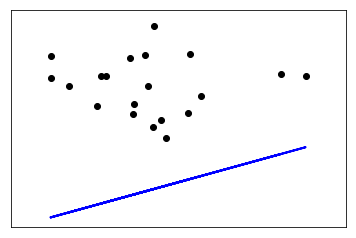

In [1]:
# print(__doc__)
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn import datasets, linear_model
# from sklearn.metrics import mean_squared_error, r2_score

# ## Load dataset
# df_I_C = pd.DataFrame()
# df_I_C['rt']=[0.38771715323451417, 0.24841261910534074, 0.1807567435524972, \
#               0.15379757490187662, 0.22698247933846483, 0.2925377928282689, \
#               0.1666398766923059, 0.17057953179010393, 0.2180424900158954, 
#               0.32640840145725697, 0.2450218810120618, 0.16269463911904347, \
#               0.23538445380851836, 0.2880961369377016, 0.3304359441596386, \
#               0.16745688050789864, 0.2968876370430828, 0.24176769993010952, \
#               0.2069469231104322, 0.2803158108786812, 0.19083033938307553, \
#               0.2747344163899315, 0.19186828350936214, 0.2528347332401746, \
#               0.3149762314520013, 0.22921054682219874, 0.13627135911239702, \
#               0.38697304048233805, 0.31847819501590136, 0.3221989882294187, \
#               0.2527230612171226, 0.21106674991039145, 0.27466700468239913, \
#               0.17734799222757974, 0.3235444720080656, 0.27581511803130426, \
#               0.16171018762941128, 0.26945388437192874]
# df_I_C['dACC']=[0.031932603251586755, -0.029252480720662555, 0.012125593873599405, \
#                 -0.005011969612112699, 0.010431609781894613, -0.03011551384948513, \
#                 0.044590452939163, 0.0017977157964697565, 0.02686214500581885, \
#                 0.016975529201946893, -0.012563490974991098, 0.000823254635602455, \
#                 0.05048616804368211, -0.004206776901867076, -0.017105154648771714, \
#                 -0.03598211082842062, 0.009346715889199608, -0.0011294658211800646, \
#                 -0.007692930163520073, 0.05892336321901798, 0.005173288768336615, \
#                 -0.004421413989281531, 0.025115467496002852, -0.018118952949897738, \
#                 0.00420941378669254, 0.029884073155729995, 0.017274684159841014, \
#                 0.01277972923041465, -0.02462936648647307, 0.009784723512831106, \
#                 0.010557574398966874, 0.005749410382607956, 0.06790347945180364, \
#                 0.015358057618862886, 0.025908268383455668, -0.006385302844275742, \
#                 0.01258024725553103, -0.024555169784802322]

# ## Use only one feature
# X = np.array([i for i in df_I_C['dACC']]).reshape(-1,1)
# y = df_I_C

# ## Split data into training/testing sets
# X_train = X[:-20]
# X_test = X[-20:]

# ## Split the targets into training/testing sets
# y_train = y.rt[:-20]
# y_test = y.rt[-20:]

# ## Create linear regression object
# regr = linear_model.LinearRegression(fit_intercept=False)

# ## Train the model using the training sets
# regr.fit(X_train, y_train)

# ## Make predictions using the testing set
# y_pred = regr.predict(X_test)

# ## The coefficients
# print('Coefficients: \n', regr.coef_)

# ## The mean squared error
# print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# ## Explained variance score: 1 is perfect prediction
# print('Variance score: %.2f' % r2_score(y_test, y_pred))

# ## Plot outputs
# plt.scatter(X_test, y_test,  color='black')
# plt.plot(X_test, y_pred, color='blue', linewidth=2)

# plt.xticks(())
# plt.yticks(())
# plt.show()

### Plot ROI ~ ROI | Linear Reg w/ Cond Hue

In [ ]:
def lmplots(df_type,sub_or_group):
    #---------------------------------##
    #  Display regplots
    #---------------------------------##  
    ## Uncomment for "Plot Group Data"
    sns.set()
    target_rois=['L_IFG','R_IFG','L_dlPFC','R_dlPFC']
    def make_plots(roi,target_rois):    
        for region in target_rois:
            slope, intercept, r_value, p_value, std_err = \
            stats.linregress(df_type['%s' % roi],df_type['%s' % region])
            g=sns.lmplot(x="%s" % roi,y="%s" % region,data=df_type,hue="group",markers=["o", "x"])
#             g=sns.lmplot(x="%s" % roi,y="%s" % region,data=df_type,hue='cond')
            plt.title("%s | r = %.2f | p = %s" % (sub_or_group,r_value,p_value))
            g.set_axis_labels('%s' % roi, '%s' % region)
            new_title = 'Group'
            g._legend.set_title(new_title)
            new_labels = ['C', 'P']
            for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
            plt.show()
        return
    make_plots("dACC",target_rois)  
    make_plots("L_IFG",target_rois[1:])
    make_plots("R_IFG",target_rois[2:])   
    make_plots("L_dlPFC",target_rois[3:])
    return
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot Group Data
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# lmplots(df,'ALL SUBJS')
# lmplots(df_hcs,'CONTROL SUBJS')
# lmplots(df_pts,'PSYCHIATRIC SUBJS')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot Data by Conditon
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# lmplots(df_I,'INCONGRUENT')
# lmplots(df_C,'CONGRUENT')
# lmplots(df_I_C,'INCONGRUENT-CONGRUENT')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot Individual Data
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# for subj in SUBJ_LIST:
#     df_sub=df.where(df['subject']==subj)
#     df_sub=df_sub.dropna()
#     lmplots(df_sub,subj.upper())

### Plot ROI ~ SS var | Linear Reg w/ Cond Hue

In [ ]:
def lmplots_ss(df_type,sub_or_group):
    ##---------------------------------##
    ##  Display regplots
    ##---------------------------------##  
    sns.set()
    target_rois=['dACC','L_IFG','R_IFG','L_dlPFC','R_dlPFC']
    def make_plots(ss_var,target_rois):
        for region in target_rois:
            slope, intercept, r_value, p_value, std_err = \
            stats.linregress(df_type['%s' % ss_var],df_type['%s' % region])
            g=sns.lmplot(x="%s" % ss_var,y="%s" % region,data=df_type,hue="group")
            plt.title("%s | r = %.2f | p = %s" % (sub_or_group,r_value,p_value))
            g.set_axis_labels('%s' % ss_var, '%s' % region)
            new_title = 'Group'
            g._legend.set_title(new_title)
            new_labels = ['C', 'P']
            for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
            plt.show()
        return
    make_plots("conflict",target_rois)  
    make_plots("adapt",target_rois)
    make_plots("rt",target_rois)
    return
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot Group Data
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# lmplots_ss(df,'ALL SUBJS')
# lmplots_ss(df_hcs,'CONTROL SUBJS')
# lmplots_ss(df_pts,'PSYCHIATRIC SUBJS')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot AVERAGED Group Data
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# lmplots_ss(df_I_C,'ALL SUBJS | Incongruent-Congruent')
# lmplots_ss(df_I,'ALL SUBJS | Incongruent')
# lmplots_ss(df_C,'ALL SUBJS | Congruent')
# lmplots_ss(df_hcs_I,'CTRL SUBJS I')
# lmplots_ss(df_hcs_C,'CTRL SUBJS C')
# lmplots_ss(df_pts_I,'PSYCH SUBJS I')
# lmplots_ss(df_pts_C,'PSYCH SUBJS C')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot Individual Data
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# for subj in SUBJ_LIST:
#     df_sub=df.where(df['subject']==subj)
#     df_sub=df_sub.dropna()
#     lmplots_ss(df_sub,subj.upper())

### Plot Joint Distributions

In [ ]:
def jpd_corr_plots(df_type1,df_type2,sub_or_group):
    ##---------------------------------##
    ##  Display JPD + correlations
    ##---------------------------------## 
    target_rois=['L_IFG','R_IFG','L_dlPFC','R_dlPFC']
    def make_joint_plots(roi,target_rois):   
        for region in target_rois:
            sns.set()
            g = sns.kdeplot(df_type1["%s" % roi],df_type1["%s" % region],\
                    cmap="Blues", shade=True, shade_lowest=False, cbar=True, labels='HCS')
            g = sns.kdeplot(df_type2["%s" % roi],df_type2["%s" % region], \
                cmap="Oranges", shade=False, shade_lowest=False, cbar=True, labels='PTS')
            plt.legend()
            plt.title("oranges = patients | blues = controls")
            plt.show()       
        return
    make_joint_plots("dACC",target_rois)  
    make_joint_plots("L_IFG",target_rois[1:])
    make_joint_plots("R_IFG",target_rois[2:])   
    make_joint_plots("L_dlPFC",target_rois[3:])
    return
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot ALL Group Data
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# jpd_corr_plots(df_hcs,df_pts,'ALL SUBJS')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot AVERAGED Group Data
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# jpd_corr_plots(df_hcs_I,df_pts_I,'Incongruent ALL SUBJS')
# jpd_corr_plots(df_hcs_C,df_pts_C,'Congruent ALL SUBJS')

### Joint plots and pair grids

In [ ]:
def pairgrid_plot(df_type,sub_or_group):
    sns.set()
    sns.axes_style('white')
    palette=sns.color_palette("Paired", 2)
    vars=["dACC","L_IFG","R_IFG","L_dlPFC","R_dlPFC","conflict","adapt","rt"]
#     g = sns.PairGrid(df_type,vars=vars,hue='subject')
    g = sns.PairGrid(df_type,vars=vars,hue='cond')
    g.map(sns.regplot)
    g.add_legend()
    plt.title('%s' % sub_or_group)
    plt.show()
    return
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot ALL Data
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# pairgrid_plot(df,'ALL SUBJS')
# pairgrid_plot(df_hcs,'CONTROL SUBJS')
# pairgrid_plot(df_pts,'PSYCHIATRIC SUBJS')
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot AVERAGED Group Data
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# pairgrid_plot(df_I,'Incongruent ALL SUBJS')
# pairgrid_plot(df_hcs_I,'Incongruent CONTROL SUBJS')
# pairgrid_plot(df_pts_I,'Incongruent PSYCHIATRIC SUBJS')
# pairgrid_plot(df_C,'Congruent ALL SUBJS')
# pairgrid_plot(df_hcs_C,'Congruent CONTROL SUBJS')
# pairgrid_plot(df_pts_C,'Congruent PSYCHIATRIC SUBJS')
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot Individual Data
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# for subj in SUBJ_LIST:
#     df_sub=df.where(df['subject']==subj)
#     df_sub=df_sub.dropna()
#     pairgrid_plot(df_sub,subj.upper())

### Distributions of Variables

In [ ]:
def df_dist(regions,df_type,subj_group,behav_vars):
    for region in regions:
        sns.distplot(df_type['%s' % region],label='%s' % region)
    plt.legend()
    plt.title(subj_group)
    plt.xlabel('ALL ROIs')
    plt.show()
    for region in regions:
        sns.distplot(df_type['%s' % region])
        plt.title(subj_group)
        plt.show()
    for var in variables:
        sns.distplot(df_type['%s' % var],label='%s' % var)
#         sns.distplot(df_type['%s' % var], kde=False, fit=stats.gamma)
    plt.legend()
    plt.title(subj_group)
    plt.xlabel('ALL Variables')
    plt.show()
    for var in variables:
        sns.distplot(df_type['%s' % var])
#         sns.distplot(df_type['%s' % var], kde=False, fit=stats.gamma)
        plt.title(subj_group)
        plt.show()
    return
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot AVERAGED Group Data
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# df_dist(regions,df_I,'Incongruent ALL SUBJS',variables)
# df_dist(regions,df_hcs_I,'Incongruent CONTROL SUBJS',variables)
# df_dist(regions,df_pts_I,'Incongruent PSYCHIATRIC SUBJS',variables)
# df_dist(regions,df_C,'Congruent ALL SUBJS',variables)
# df_dist(regions,df_hcs_C,'Congruent CONTROL SUBJS',variables)
# df_dist(regions,df_pts_C,'Congruent PSYCHIATRIC SUBJS',variables)

### Linear Mixed Effects Model

In [ ]:
# def mixed_LM(df_type,sub_or_group):
#     for beta in ['dACC','L_IFG','R_IFG','L_dlPFC','R_dlPFC']:
#         for ss_v in ['conflict','adapt','rt']:
#             md = smf.mixedlm('%s ~ %s' % (reg,ss_v),data=df_type,groups="group")
#             mdf = md.fit()
#             print(mdf.summary())
#     return
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# mixed_LM(df,'ALL SUBJS')
# mixed_LM(df_hcs,'CONTROL SUBJS')
# mixed_LM(df_pts,'PSYCHIATRIC SUBJS')
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

### *DEPRECIATED: Modify this section to reflect updated ss model*

The MSIT state space model is as follows:

$$
RT(k) = \beta_0 + \beta_1 * Interference + X_{ss}(k)
$$
where
$$
X_{ss}(k) = X_{ss}(k - 1) + W
$$

Interference is 1 if the current trial k is an incongruent trial and 0 if it is a congruent trial.